In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
# from keras.utils import np_utils, to_categorical # this line was changed
from keras.utils import to_categorical # this line was added
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
  warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
dataset=pd.read_csv("/content/updated_data_with_mugging.csv")

In [ ]:
from scipy.signal import resample
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    number_of_samples = int(len(data) / rate)
    stretched_data = resample(data, number_of_samples)
    return stretched_data

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)


# taking any example and checking for techniques.
path = np.array(dataset.Path)[1]
data, sample_rate = librosa.load(path)

In [ ]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally

    return result

In [ ]:
dataset.head()

,Emotions,Path
0,not mugging,/content/drive/MyDrive/RAVDESS/audio_speech_ac...
1,not mugging,/content/drive/MyDrive/RAVDESS/audio_speech_ac...
2,not mugging,/content/drive/MyDrive/RAVDESS/audio_speech_ac...
3,not mugging,/content/drive/MyDrive/RAVDESS/audio_speech_ac...
4,mugging,/content/drive/MyDrive/RAVDESS/audio_speech_ac...


In [ ]:
# Define the path where you want to save the file in your Google Drive
Features = pd.read_csv('/content/drive/MyDrive/featuress.csv')

In [ ]:
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.264025,0.610264,0.674106,0.708518,0.733163,0.679862,0.621189,0.614429,0.638012,0.659570,...,1.233707e-05,1.363080e-05,1.991353e-05,4.830410e-05,8.079475e-05,1.352846e-04,1.716032e-04,5.727524e-05,3.713600e-06,not mugging
1,0.295894,0.725903,0.767576,0.796374,0.820471,0.811479,0.746907,0.654453,0.664581,0.712573,...,1.437516e-04,1.368006e-04,1.442466e-04,1.756525e-04,2.185184e-04,2.517310e-04,3.039300e-04,1.813700e-04,1.326845e-04,not mugging
2,0.222609,0.695615,0.631123,0.617891,0.634996,0.657911,0.657789,0.639339,0.629107,0.608686,...,7.130395e-07,6.058706e-12,4.110885e-16,1.306799e-16,7.859018e-17,6.600157e-17,6.540497e-17,6.952504e-17,7.967406e-17,not mugging
3,0.204187,0.697181,0.686450,0.690078,0.706820,0.673175,0.659655,0.657918,0.687829,0.682273,...,1.773611e-05,1.268163e-05,8.949025e-06,5.730517e-06,3.649699e-06,3.963375e-06,4.395089e-06,5.196617e-06,5.001726e-07,not mugging
4,0.254779,0.740578,0.737064,0.754268,0.800620,0.768030,0.694261,0.629636,0.666652,0.688270,...,6.639184e-05,5.859467e-05,5.785033e-05,5.423547e-05,5.062223e-05,4.948833e-05,5.281765e-05,5.285973e-05,4.742411e-05,not mugging


In [ ]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [ ]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [ ]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((29304, 162), (29304, 2), (9768, 162), (9768, 2))

In [ ]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((29304, 162), (29304, 2), (9768, 162), (9768, 2))

In [ ]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((29304, 162, 1), (29304, 2), (9768, 162, 1), (9768, 2))

In [ ]:
if len(x_train.shape) == 2:
    x_train = np.expand_dims(x_train, axis=-1)
if len(x_test.shape) == 2:
    x_test = np.expand_dims(x_test, axis=-1)

print("Reshaped x_train shape:", x_train.shape)
print("Reshaped x_test shape:", x_test.shape)

Reshaped x_train shape: (29304, 162, 1)
Reshaped x_test shape: (9768, 162, 1)


In [ ]:
# Define the model
model = Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
model.add(Dropout(0.2))
model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=2, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 162, 256)          1536      
                                                                 
 max_pooling1d (MaxPooling1  (None, 81, 256)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 81, 256)           327936    
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 41, 256)           0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 41, 128)           163968    
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 21, 128)           0

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Define the learning rate reduction callback
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=1, patience=2, min_lr=0.0000001)

# Train the model and save the history
history = model.fit(x_train, y_train, batch_size=32, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
916/916 [==============================] - 17s 10ms/step - loss: 0.6143 - accuracy: 0.6620 - val_loss: 0.6037 - val_accuracy: 0.6469 - lr: 0.0010
Epoch 2/50
916/916 [==============================] - 11s 12ms/step - loss: 0.5530 - accuracy: 0.7036 - val_loss: 0.5268 - val_accuracy: 0.7102 - lr: 0.0010
Epoch 3/50
916/916 [==============================] - 9s 10ms/step - loss: 0.5114 - accuracy: 0.7287 - val_loss: 0.4914 - val_accuracy: 0.7257 - lr: 0.0010
Epoch 4/50
916/916 [==============================] - 7s 8ms/step - loss: 0.4916 - accuracy: 0.7390 - val_loss: 0.4873 - val_accuracy: 0.7310 - lr: 0.0010
Epoch 5/50
916/916 [==============================] - 13s 15ms/step - loss: 0.4780 - accuracy: 0.7470 - val_loss: 0.4713 - val_accuracy: 0.7431 - lr: 0.0010
Epoch 6/50
916/916 [==============================] - 11s 12ms/step - loss: 0.4680 - accuracy: 0.7516 - val_loss: 0.4652 - val_accuracy: 0.7439 - lr: 0.0010
Epoch 7/50
916/916 [==============================] - 7s 8ms/

In [ ]:
drive_path = '/content/drive/MyDrive/mugging_detection_model'

In [ ]:
import pickle
# Save the model
model.save(os.path.join(drive_path, 'muugging_detection_model.h5'))

# Save the history
with open(os.path.join(drive_path, 'history.pkl'), 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from tensorflow.keras.models import load_model
# Load the saved model
model = load_model(os.path.join(drive_path, 'muugging_detection_model.h5'))

In [ ]:
import pickle

# Load the history
history_path = os.path.join(drive_path, 'history.pkl')
with open(history_path, 'rb') as file_pi:
    history = pickle.load(file_pi)

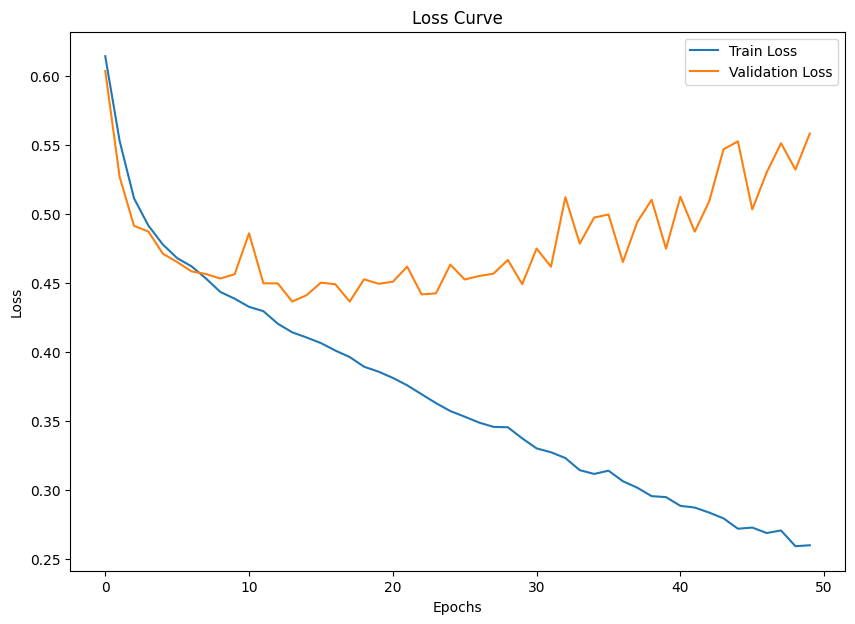

In [ ]:
# Plotting the loss curve
plt.figure(figsize=(10, 7))
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

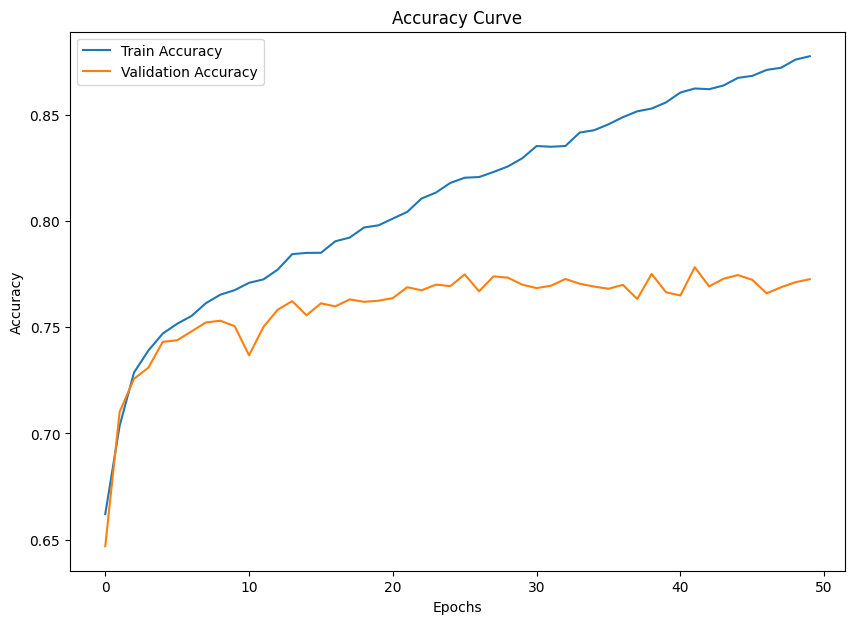

In [ ]:
# Plotting the accuracy curve
plt.figure(figsize=(10, 7))
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model
evaluation = model.evaluate(x_test, y_test)
accuracy = evaluation[1] * 100
print("Accuracy of our model on test data:", accuracy, "%")

306/306 [==============================] - 2s 4ms/step - loss: 0.5583 - accuracy: 0.7726
Accuracy of our model on test data: 77.26249098777771 %


In [ ]:
# Predictions
y_pred = model.predict(x_test)

306/306 [==============================] - 1s 2ms/step


In [ ]:
# Converting predictions to label
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

In [ ]:
from sklearn.metrics import classification_report, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
# F1 score
f1 = f1_score(y_test_labels, y_pred_labels, average='weighted')
print("F1 Score: ", f1)

# AUC Score
auc_score = roc_auc_score(y_test, y_pred, multi_class='ovr')
print("AUC Score: ", auc_score)

# Classification Report
print("Classification Report:\n", classification_report(y_test_labels, y_pred_labels))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)
print("Confusion Matrix:\n", conf_matrix)

F1 Score:  0.7696215508476922
AUC Score:  0.8516499618637612
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.85      0.83      6319
           1       0.70      0.63      0.66      3449

    accuracy                           0.77      9768
   macro avg       0.75      0.74      0.74      9768
weighted avg       0.77      0.77      0.77      9768

Confusion Matrix:
 [[5383  936]
 [1285 2164]]


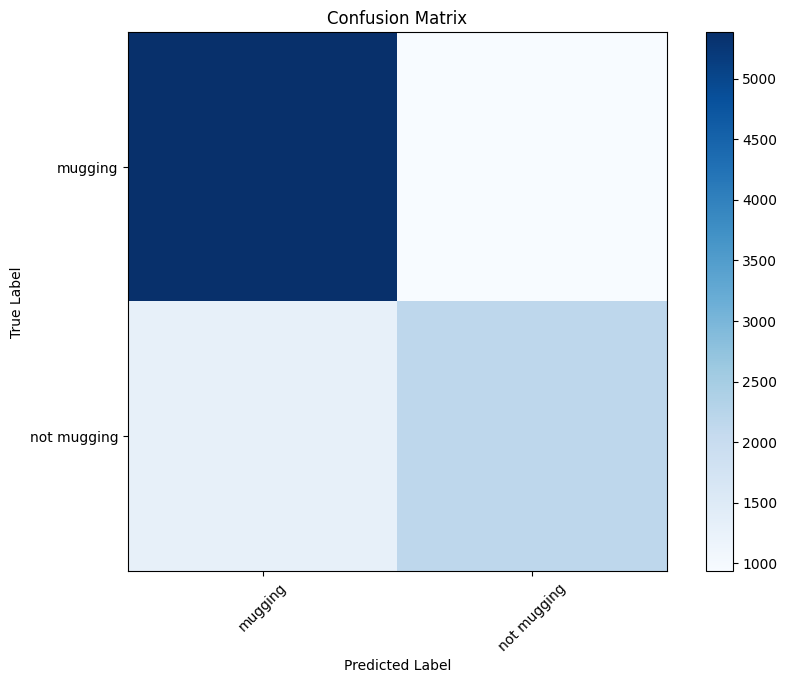

In [ ]:
# Plot Confusion Matrix
plt.figure(figsize=(10, 7))
plt.imshow(conf_matrix, cmap='Blues', interpolation='none')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(len(encoder.categories_[0])), encoder.categories_[0], rotation=45)
plt.yticks(np.arange(len(encoder.categories_[0])), encoder.categories_[0])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

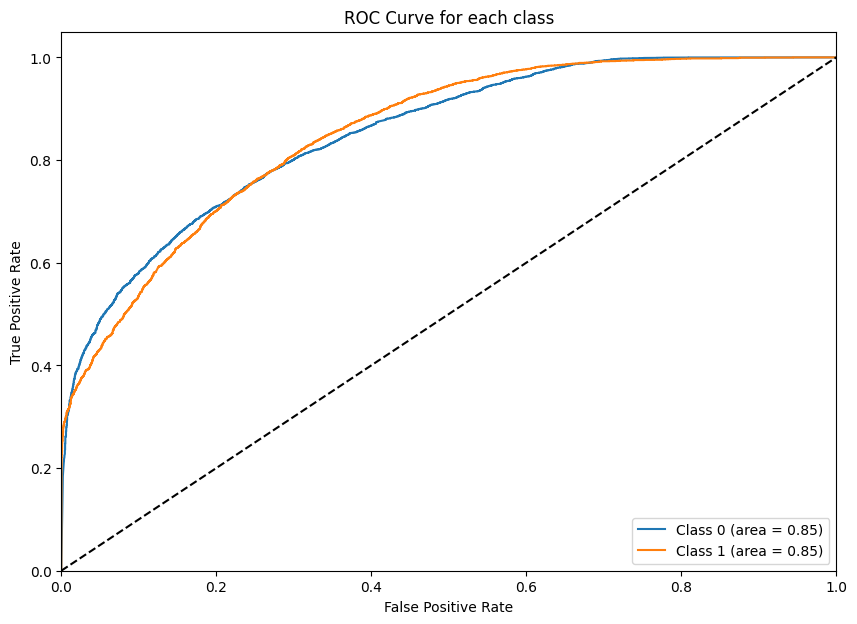

In [ ]:
# Plot ROC Curves for each class
plt.figure(figsize=(10, 7))
for i in range(y_test.shape[1]):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred[:, i])
    plt.plot(fpr, tpr, label=f'Class {i} (area = {auc(fpr, tpr):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for each class')
plt.legend(loc='lower right')
plt.show()

In [ ]:

import numpy as np
import pickle
import librosa

# Function to load and preprocess an audio file
def preprocess_audio(file_path):
    data, sample_rate = librosa.load(file_path, duration=2.5, offset=0.6)
    feature = extract_features(data)
    feature = scaler.transform([feature])
    feature = np.expand_dims(feature, axis=2)
    return feature


# Load the encoder and scaler
with open(os.path.join(drive_path, 'encoder.pkl'), 'rb') as f:
    encoder = pickle.load(f)
with open(os.path.join(drive_path, 'scaler.pkl'), 'rb') as f:
    scaler = pickle.load(f)

# Function to predict mugging or not mugging
def predict_mugging(file_path):
    feature = preprocess_audio(file_path)
    prediction = model.predict(feature)
    predicted_label = encoder.inverse_transform(prediction)
    return predicted_label[0]

In [ ]:
# Example usage
uploaded_file_path = '/content/drive/MyDrive/TESS/tess toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_happy/YAF_back_happy.wav'
prediction = predict_mugging(uploaded_file_path)
print("Prediction:", prediction)

1/1 [==============================] - 0s 361ms/step
Prediction: ['not mugging']
